# Loading Libraries and Initialize


In [1]:
%%capture
%run -i 2-SimpleMovingAverage.ipynb

In [4]:
df['mean'] = df['close'].mean()

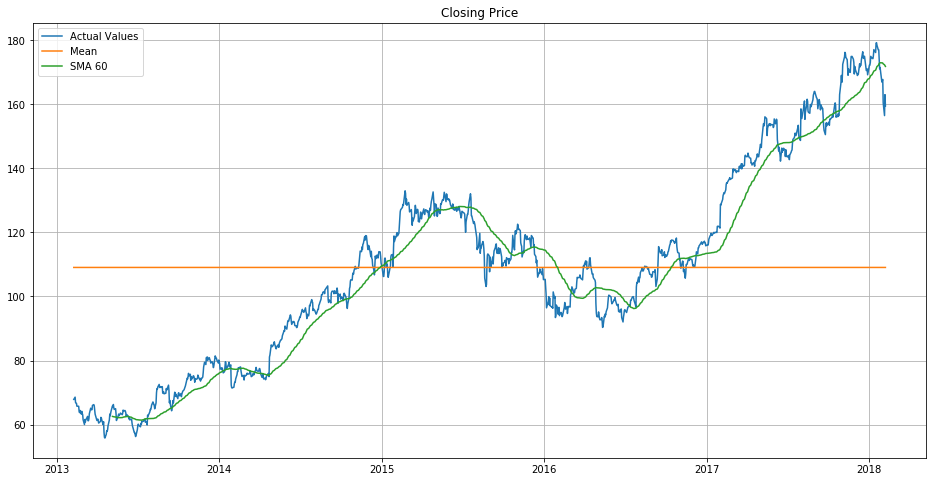

In [9]:
plt.figure(figsize=(16,8))
plt.title('Closing Price')

plt.plot(df['close'], label='Actual Values')
plt.plot(df['mean'], label='Mean')
plt.plot(df['sma60'], label='SMA 60')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [16]:
SStot = ((df['close'] - df['mean']) ** 2).sum()
SSres5 = ((df['close'] - df['sma5']) ** 2).sum()
SSres15 = ((df['close'] - df['sma15']) ** 2).sum()
SSres30 = ((df['close'] - df['sma30']) ** 2).sum()
SSres60 = ((df['close'] - df['sma60']) ** 2).sum()
print(SStot, SSres5, SSres15, SSres30, SSres60)
R2_5 = 1 - (SSres5/SStot)
R2_15 = 1 - (SSres15/SStot)
R2_30 = 1 - (SSres30/SStot)
R2_60 = 1 - (SSres60/SStot)
print(R2_5, R2_15, R2_30, R2_60)

1174618.174745747 3742.6452237042795 14116.035080405756 29944.71572913726 57464.84231853302
0.9968137346210275 0.9879824479274201 0.9745068513556595 0.9510778535918946


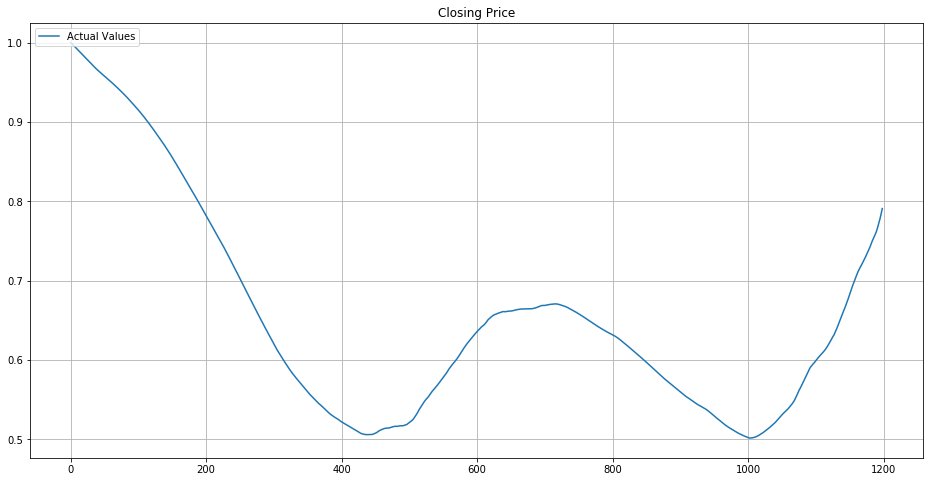

In [41]:
SStot = ((df['close'] - df['mean']) ** 2).sum()
df1 = df
R2s =  []

for i in range(1, 1200):
    df1['sma'] = simple_moving_average(df['close'], i)
    SSres = ((df['close'] - df1['sma']) ** 2).sum()
    R2 = 1 - (SSres/SStot)
    R2s.append(R2)

plt.figure(figsize=(16,8))
plt.title('Closing Price')

plt.plot(R2s, label='Actual Values')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

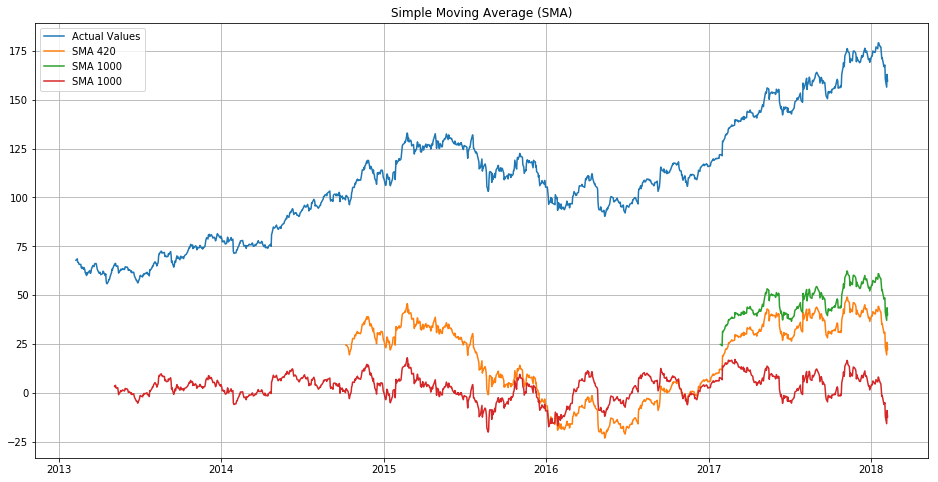

In [39]:
df2 = df
df2['a'] = simple_moving_average(df['close'], 420)
df2['b'] = simple_moving_average(df['close'], 1000)
df2['c'] = simple_moving_average(df['close'], 60)
plt.figure(figsize=(16,8))
plt.title('Simple Moving Average (SMA)')

plt.plot(df2['close'], label='Actual Values')
plt.plot(df2['close'] - df2['a'], label='SMA 420'.format(window))
plt.plot(df2['close'] - df2['b'], label='SMA 1000'.format(window))

plt.plot(df2['close'] - df2['c'], label='SMA 1000'.format(window))

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize              # for function minimization

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


In [ ]:
%%time
data = appleData['close'][:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()